In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
# FUNCTIONS AND DECLARATIONS
# This now works 10 times faster
#
# DRAWBACKS: still too slow learning 
# ADVANTAGES:
#   1. much faster forward pass (most weights are zeros, powers of 2 when not)
#   2. no vanishing gradient problem from back-propagation, all weights are treated equally
#   3. possibility of choosing layer, not whole network
#   4. overfitting?

import tensorflow as tf
from tensorflow import keras

from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical

import random
import numpy as np
import os.path
import copy

import time # for 12 hours limit
import datetime

def layer_size(layer):
    weights = layer.get_weights()
    return len(weights[0]) + len(weights[1])

def model_size(model):
    result = 0
    for layer in model.layers:
        result += layer_size(layer)
    return result

def random_layer_num(model):
    probabilities = []
    total_weights = model_size(model)
    for layer in model.layers:
        probabilities.append(layer_size(layer) / total_weights)
    return np.random.choice(len(probabilities), p=probabilities)

def spsa_fit(model, model_name, train_images, train_labels, epochs, spsa_step = 8, min_spsa_step = 0.005, min_value_loss = 0.1, max_steps_without_change = 500, time_calc_limit = 43000):
    start_time = time.time()  
    count = 0               # the counter for adjusting the SPSA step  (see max_steps_without_change)           

    # THE MAIN CYCLE
    # Начинается главный цикл обучения
    print("START: ", datetime.now())
    # Инициализируем значение лосс функции равной минус единице
    loss_value = -1
    for epoch in range(epochs):     
        # каждые 1000 эпох выведем номер текущей эпохи
        if epoch % 1000 == 0:
            print("\nStart of epoch %d" % (epoch,))

        # Adjust the SPSA step
        # Уменьшаем шаг обновления весов нейросети в два раза, если лосс функция  не уменьшалась определённое количество эпох
        # Это метод аналогичный tf.keras.callbacks.ReduceLROnPlateau() для лёрнинг рейт
        if count >= max_steps_without_change:
            spsa_step = spsa_step / 2  
            count = 0

        # create random weight distortion
        # Выбираем рандомный слой из всех слоёв нейросети
        layers = [layer for layer in model.layers]
        random_layer = layers[random_layer_num(model)]
        # берём веса на из этого рандомного слоя
        weights = random_layer.get_weights()
        # случайным образом выбирается индекс тензора, который будет меняться. Он выбирается из равномерного распределения, между весами и баясами слоя. Это будет либо тензор с весами, либо с биасами слоя.
        random_tensor = np.random.choice(len(weights), p=[len(weights[0])/(len(weights[0])+len(weights[1])), len(weights[1])/(len(weights[0])+len(weights[1]))])
        # записывается размер данного тензора
        selected_shape = len(weights[random_tensor].shape)
        random_weight_index_1 = random.randint(0, weights[random_tensor].shape[0] - 1)

        # копируются веса слоя дважды в разные переменные
        weights_1 = copy.deepcopy(weights)
        weights_2 = copy.deepcopy(weights)
        if selected_shape == 2:
            # если размер тензора равен двум (это матрица), то генерируется второй рандомный индекс
            random_weight_index_2 = random.randint(0, weights[random_tensor].shape[1] - 1)
            # обновляем веса выбронного нами тензора на заданый ранее шаг. Прибавляем и отнимаем соответственно.
            weights_1[random_tensor][random_weight_index_1][random_weight_index_2] = weights[random_tensor][random_weight_index_1][random_weight_index_2] + spsa_step 
            weights_2[random_tensor][random_weight_index_1][random_weight_index_2] = weights[random_tensor][random_weight_index_1][random_weight_index_2] - spsa_step 
        else:
            # если размер тензора равен 1 (это вектор), соответственно обновляем его веса
            weights_1[random_tensor][random_weight_index_1] = weights[random_tensor][random_weight_index_1] + spsa_step 
            weights_2[random_tensor][random_weight_index_1] = weights[random_tensor][random_weight_index_1] - spsa_step 
            random_weight_index_2 = -1

        # run 0, for the first time only
        
        if loss_value < 0:
            # Если это первый запуск, сделаем дополнительный форвард пропагейшн, чтобы посчитать начальное значение лосс функции
            logits_0 = model(train_images, training=False)
            loss_value0 = loss_fn(train_labels, logits_0)
        else:
            # в противном случае, установить начальным значением лосс функции, лосс полученный на предыдущей эпохе
            loss_value0 = loss_value
        # устанавливаются новые значение весов модели и вычисляется результат форвард пропагейшн на всём датасете. 
        # для двух изменённых весов соответственно
        random_layer.set_weights(weights_1)
        logits_1 = model(train_images, training=False)
        random_layer.set_weights(weights_2)
        logits_2 = model(train_images, training=False)

        # вычисление лосс функции
        loss_value1 = loss_fn(train_labels, logits_1)
        loss_value2 = loss_fn(train_labels, logits_2)

        #update weight
        count += 1    # assume there's no positive change of loss function, maybe the step is too large
        # в зависимости от значений лосс функции выбирает лучшие значения весов из изменённых.
        if loss_value1 < loss_value0 and loss_value1 < loss_value2:
            random_layer.set_weights(weights_1)
            if (loss_value0 - loss_value1) > loss_value0 * 0.001:
                count = 0
            loss_value = loss_value1
        elif loss_value2 < loss_value0:
            if (loss_value0 - loss_value2) > loss_value0 * 0.001:
                count = 0
            loss_value = loss_value2
        else:
            loss_value = loss_value0
            random_layer.set_weights(weights)

        # Log 
        if epoch % 1000 == 0:
            print("Training loss (for one batch): %.4f" % (float(loss_value)))
            print("spsa step: %f" % (spsa_step)) 

        # EXIT since we achieved the goal
        # завершение обучения если лосс функция слишком мала
        if loss_value <= min_value_loss: 
            print("\nWe reach minimal value") 
            model_name += '_(minimal value)'
            break

        # EXIT since it takes too long, Google Colab will interrupt us soon
        # завершение обучения, если оно обучается слишком долго
        if time_calc_limit <= (time.time() - start_time):
            print("\nWe reach limit of time")
            model_name += '_(limit of time)'
            break

        # EXIT since the step became too small
        # завершение обучения если шаг изменения весов слишком мал
        if spsa_step < min_spsa_step:
            print("\nWe reach the minimal step size")
            model_name += '_(step too small)'
            break

    print("\n\nFINISH: ", datetime.now())
    print("Seconds consumed: ", time.time() - start_time)

    # save model
    model.save_weights("/content/drive/My Drive/" + model_name + ".h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 
# Train 2 networks, our method vs Adam
#
# from urllib.request import urlopen
exec(open("/content/track.py").read())
_colabMonitor = ColabMonitor(interval=0.001).start()
print('interval time:', _colabMonitor._interval)

# MNIST data
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#
# Our model, zero weights
#
model = models.Sequential()
init_scheme = tf.keras.initializers.Zeros()
model.add(layers.Dense(512, activation='relu', kernel_initializer = init_scheme, bias_initializer = 'zeros', input_shape=(28 * 28,)))
model.add(layers.Dense(10024, activation='relu'))
model.add(layers.Dense(2024, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 

# Train our model
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
spsa_fit(model, 'mnist_1_layer_0903_2', train_images, train_labels, epochs = 2, spsa_step = 8, min_spsa_step = 1, min_value_loss = 0.1, max_steps_without_change = 10000, time_calc_limit = 43000)

# Check the accuracy
optimizer = keras.optimizers.RMSprop()
# model.compile(optimizer, loss_fn, metrics=['accuracy'])
# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print("\n\n\ntest_loss: {0}, test_acc: {1}".format(test_loss, test_acc))

#
# Book model
#
time.sleep(5)
book_network = models.Sequential()
book_network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
book_network.add(layers.Dense(10024, activation='relu'))
book_network.add(layers.Dense(2024, activation='relu'))
book_network.add(layers.Dense(10, activation='softmax'))
book_network.compile(optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['accuracy'])
time.sleep(1)
# Train
start = time.time()
# logits_0 = book_network(train_images, training=False)
# time.sleep(2)
# logits_0 = book_network(train_images, training=False)
book_network.fit(train_images, train_labels, epochs=2, batch_size=60000)
print("\n\nSeconds consumed (book model): ", time.time() - start)
time.sleep(1)
# test_loss, test_acc = book_network.evaluate(test_images, test_labels)
# print("\n\n\ntest_loss: {0}, test_acc: {1}".format(test_loss, test_acc))


#
#  COMPARE FORWARD PASS!
#
# start = time.time()
# for i in range(100):
#     model(train_images, training=False)
# print("\n\nOur model, forward pass, seconds consumed: ", time.time() - start)
# start = time.time()
# for i in range(100):
#     book_network(train_images, training=False)
# print("\n\nBook model, forward pass, seconds consumed: ", time.time() - start)

filename = _colabMonitor.get_name()
_colabMonitor.stop()

interval time: 0.001
START:  2021-06-03 15:09:49.401141

Start of epoch 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentrop

Training loss (for one batch): 2.3026
spsa step: 8.000000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '




FINISH:  2021-06-03 15:09:52.762807
Seconds consumed:  3.362704038619995
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 2.2974 - accuracy: 0.1189
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 1.8469 - accuracy: 0.4737


Seconds consumed (book model):  4.488980770111084


In [ ]:
#
#  COMPARE FORWARD PASS!
#
start = time.time()
for i in range(10):
    #model.evaluate(test_images, test_labels)
    model(train_images[0:128], training=False)
print("\n\nOur model, forward pass, seconds consumed: ", time.time() - start)
start = time.time()
for i in range(10):
    #book_network.evaluate(test_images, test_labels)
    book_network(train_images[0:128], training=False)
print("\n\nBook model, forward pass, seconds consumed: ", time.time() - start)



Our model, forward pass, seconds consumed:  0.021713733673095703


Book model, forward pass, seconds consumed:  0.017334938049316406


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import json
import os


# Reading the json as a dict
with open(filename, 'r') as json_data:
    data = json.load(json_data)

    interval = data['interval']
    del data['interval']

    total_virt_mem  = data['total_virt_mem']
    del data['total_virt_mem']

    total_gpu_mem = data['total_gpu_mem']
    del data['total_gpu_mem']

    gpu_name = data['gpu_name']
    del data['gpu_name']

    total_disk_space = data['total_disk_space']
    del data['total_disk_space']

    del data['tpu_mxu']
    del data['tpu_idle']

print(interval)
# using the from_dict load function. Note that the 'orient' parameter 
#is not using the default value (or it will give the same error that you got before)
# We transpose the resulting df and set index column as its index to get this result
df = pd.DataFrame.from_dict(data)  
df[['CPU0','CPU1']] = pd.DataFrame(df.cpus_load.tolist(), index=df.index)

0.001


In [ ]:
df

,5m_loadavg,cpus_load,virt_mem,disk_usage,net_sent,net_recv,gpu_load,gpu_mem,time,interval_time,CPU0,CPU1
0,3.89,"[8.8, 7.8]",0.153,0.266,0.000000,0.000000,0.0,0.59183,0.051680,0.051680,8.8,7.8
1,3.89,"[71.4, 100.0]",0.153,0.266,0.000000,0.000000,0.0,0.59183,0.102390,0.050710,71.4,100.0
2,3.89,"[83.3, 83.3]",0.153,0.266,0.000000,0.000000,0.0,0.59183,0.162223,0.059833,83.3,83.3
3,3.89,"[80.0, 83.3]",0.153,0.266,0.013552,0.012421,0.0,0.59183,0.217645,0.055422,80.0,83.3
4,3.89,"[80.0, 100.0]",0.153,0.266,0.003228,0.003228,0.0,0.59183,0.268699,0.051053,80.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
261,3.89,"[25.0, 50.0]",0.149,0.266,0.000000,0.000000,0.0,0.59183,14.271774,0.039878,25.0,50.0
262,3.89,"[50.0, 50.0]",0.149,0.266,0.000000,0.000000,0.0,0.59183,14.315578,0.043804,50.0,50.0
263,3.89,"[50.0, 33.3]",0.149,0.266,0.000000,0.000000,0.0,0.59183,14.360034,0.044456,50.0,33.3
264,3.89,"[66.7, 50.0]",0.149,0.266,0.000000,0.000000,0.0,0.59183,14.403288,0.043254,66.7,50.0


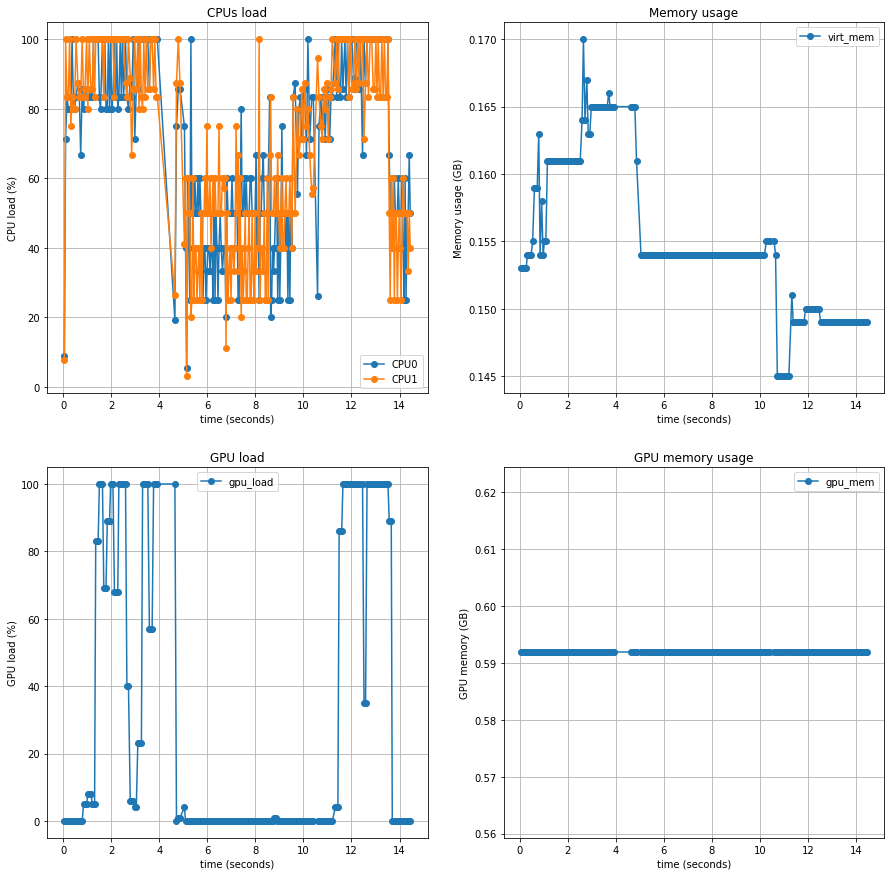

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
# X = np.linspace(0, len(df.CPU0)*interval, num=len(df.CPU0))
X = df.time
axs[0,0].set_title('CPUs load')
axs[0,0].plot(X, df.CPU0, 'o-', label='CPU0')
axs[0,0].plot(X, df.CPU1, 'o-', label='CPU1')
axs[0,0].set_xlabel('time (seconds)')
axs[0,0].set_ylabel('CPU load (%)')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].set_title('Memory usage')
axs[0,1].plot(X, df.virt_mem, 'o-', label='virt_mem')
axs[0,1].set_xlabel('time (seconds)')
axs[0,1].set_ylabel('Memory usage (GB)')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].set_title('GPU load')
axs[1,0].plot(X, df.gpu_load, 'o-', label='gpu_load')
axs[1,0].set_xlabel('time (seconds)')
axs[1,0].set_ylabel('GPU load (%)')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].set_title('GPU memory usage')
axs[1,1].plot(X, df.gpu_mem, 'o-', label='gpu_mem')
axs[1,1].set_xlabel('time (seconds)')
axs[1,1].set_ylabel('GPU memory (GB)')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()

In [ ]:
!nvidia-smi --query-gpu=index,uuid,utilization.gpu,memory.total --format=csv,noheader,nounits

0, GPU-863077b5-c3d9-0d49-6d2f-63587c0303f9, 0, 16280


In [ ]:
l = [3,4,22,3,44,52]

In [ ]:
l[-3]

3